# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.shape

(7591, 2)

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


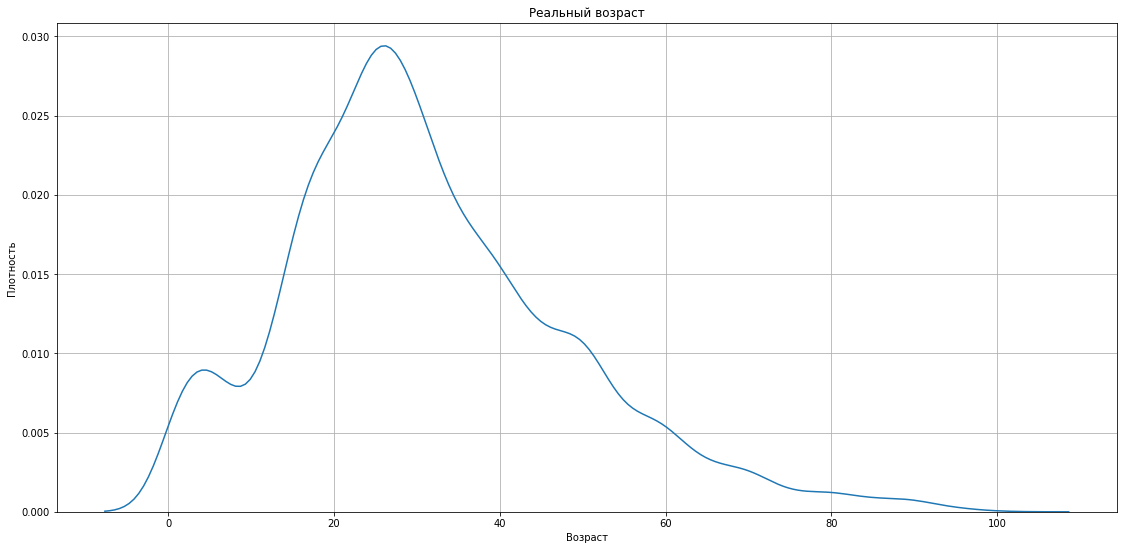

In [6]:
plt.figure(figsize=(19,9))
plt.title("Реальный возраст")
plt.xlabel("Возраст")
plt.ylabel("Плотность")
plt.grid(True)
sns.kdeplot(data=labels, x='real_age');

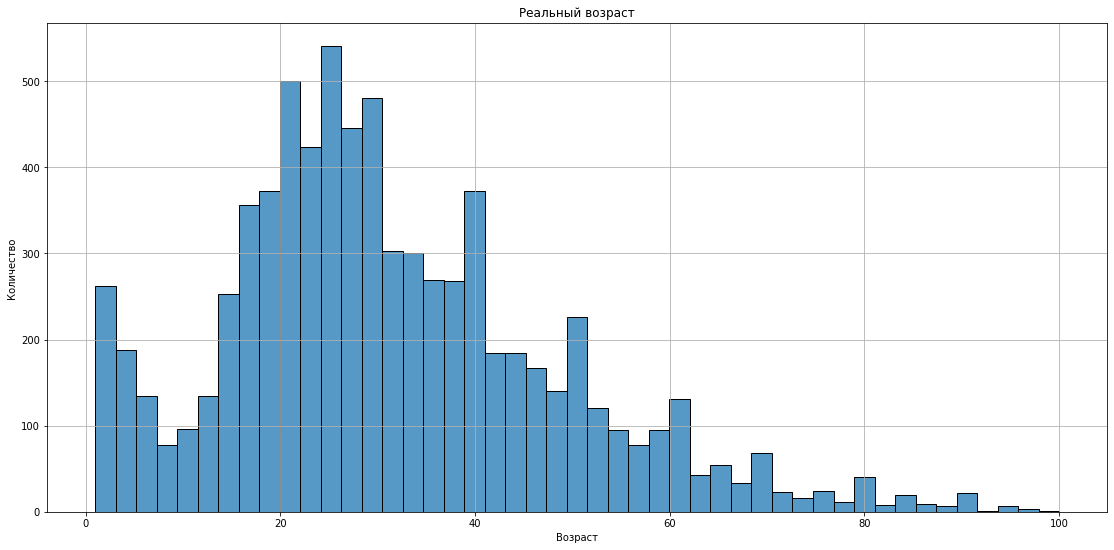

In [7]:
plt.figure(figsize=(19,9))
plt.title("Реальный возраст")
plt.xlabel("Возраст")
plt.ylabel("Количество")
plt.grid(True)
sns.histplot(data=labels, x='real_age');

In [8]:
datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        width_shift_range=0.2, height_shift_range=0.2,
        rescale=1/255.)

In [9]:
photo_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [10]:
photo, target = next(photo_gen_flow)

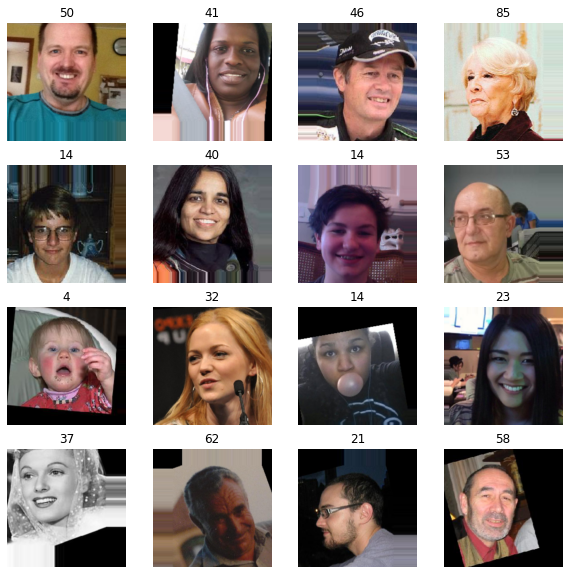

In [11]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.title(target[i])
    plt.imshow(photo[i])
    plt.axis('off')
    

- В наборе 7591 фотографий, для каждой фотографии представлена информация о реальном возрасте человека
- Пропуски отсутствуют
- Реальный возраст подавляющего числа людей на фотографиях от 20 до 41 года

Просмотр фотографий показал - в основном на всех фотографиях лица людей расположены в фас и анфас, реже в профиль, есть фотографии с большими углами поворота, чёрно-белые и с посторонними предметами на фоне лица.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
RND=12345

def load_train(path):  
    train_data=pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       horizontal_flip=True,
                                       rescale=1./255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
                                                        dataframe=train_data,
                                                        directory=path + '/final_files/',
                                                        x_col='file_name',
                                                        y_col='real_age',
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        class_mode='raw',
                                                        subset='training',
                                                        seed=RND)
    return train_datagen_flow


def load_test(path):

    test_data=pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25,
                                      rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=test_data,
                                                         directory=path + '/final_files/',
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode='raw',
                                                         subset='validation',
                                                         seed=RND)
    return test_datagen_flow



def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              shuffle=True)

    return model

```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.
Train for 178 steps, validate for 60 steps

Epoch 1/5
78/178 - 73s - loss: 232.5069 - mae: 10.9267 - val_loss: 834.7133 - val_mae: 23.9988
Epoch 2/5
178/178 - 41s - loss: 78.0959 - mae: 6.6577 - val_loss: 465.4237 - val_mae: 16.2058
Epoch 3/5
178/178 - 43s - loss: 48.7842 - mae: 5.2899 - val_loss: 199.9761 - val_mae: 10.4677
Epoch 4/5
178/178 - 42s - loss: 35.4911 - mae: 4.5498 - val_loss: 136.9889 - val_mae: 8.5346
Epoch 5/5
178/178 - 46s - loss: 28.7718 - mae: 4.1035 - val_loss: 78.2778 - val_mae: 6.6060
60/60 - 11s - loss: 78.2778 - mae: 6.6060
Test MAE: 6.6060
```

## Анализ обученной модели

Наилучший результат MAE: 6.61 получен при использовании архитектуры ResNet с алгоритмом Adam, с скоростью обучения 0.0001, за 5 эпох, с установленным количеством изображений в батче в размере 32шт.